In [17]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import spectrogram, stft, istft, check_NOLA

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor
from collections import OrderedDict
import os
import neptune
from neptune.utils import stringify_unsupported

plt.style.use('ggplot')

# PARAMETERS - GENERAL

In [2]:
stftSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/trainTestRTheta.npz'
timeDomainSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/trainTestTimeDomain.npz'

modelPath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/pytorchModels/model.pth'

neptuneProject = 'jettinger35/predictScalp'
api_token = os.environ.get('NEPTUNE_API_TOKEN')

subsampleFreq = 128   # FINAL FREQUENCY IN HERTZ AFTER SUBSAMPLING
secondsInWindow = 1.
nperseg = subsampleFreq * secondsInWindow
noverlap = nperseg - 1
window = ('tukey', .25)

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# PARAMETERS - TRAINING

In [30]:
epochs = 5000
batch_size = 64
learningRate = 1e-4
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()
optChoice = 'adam'

patience = 50

# UTILITY FUNCTIONS

In [4]:
# CONVERT STFT FROM R,THETA TO COMPLEX
# dim(z) = (# timesteps, # freq bins x 2 (2 reals = 1 complex))

def rThetaToComplex(z):
    rows, cols = z.shape
    shortTermFourier = np.zeros((rows, cols // 2), dtype=np.csingle)
    for i in range(rows):
        for k in range(cols // 2):
            r = z[i,k]
            theta = z[i, (k + cols // 2)]
            shortTermFourier[i,k] =  r * np.exp(complex(0, theta))
    return shortTermFourier.transpose() # dim = (# freq bins, # timepoints)

# CONVERT REAL STFT TO COMPLEX STFT, INVERT TO GET THE ISTFT (I.E. TIME SERIES), THEN PLOT

def realSTFTtoTimeSeries(realSTFT):
    shortTermFourierComplex = rThetaToComplex(realSTFT)
    times, inverseShortFourier = istft(shortTermFourierComplex, 
                                       fs=subsampleFreq, 
                                       window=window, 
                                       nperseg=nperseg, 
                                       noverlap=noverlap)
    return times, inverseShortFourier

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        return loss
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

class NeuralNetwork(nn.Module):
    
    def __init__(self, layerOrderedDict):
        super().__init__()
        self.model = nn.Sequential(layerOrderedDict)
        
    def forward(self, x):
        return self.model(x)
    
    
# GIVEN A LIST OF LAYER SIZES MAKE AN ORDERED DICTIONARY FOR INITIALIZING A PYTORCH NET

def listToOrderedDict(sizeList):
    n = len(sizeList)
    tupleList = []
    for i in range(n - 1):
        tupleList.append(('l%s' % str(i), nn.Linear(sizeList[i], sizeList[i+1])))
        tupleList.append(('r%s' % str(i), nn.ReLU()))
    return OrderedDict(tupleList[:-1])

# LOAD NUMPY DATA ARRAYS

In [5]:
# STFT DATA

npzfile = np.load(stftSavePath)
x_trainRTheta = npzfile['x_trainRTheta']
x_validRTheta = npzfile['x_validRTheta'] 
y_trainRTheta = npzfile['y_trainRTheta'] 
y_validRTheta = npzfile['y_validRTheta']

trainXTensor = torch.Tensor(x_trainRTheta)
trainYTensor = torch.Tensor(y_trainRTheta)
validXTensor = torch.Tensor(x_validRTheta)
validYTensor = torch.Tensor(y_validRTheta)

In [20]:
# TIME DOMAIN DATA

npzfile = np.load(timeDomainSavePath)
xTrainTimeDomain = npzfile['xTrainTimeDomain']
xValidTimeDomain = npzfile['xValidTimeDomain'] 
yTrainTimeDomain = npzfile['yTrainTimeDomain'] 
yValidTimeDomain = npzfile['yValidTimeDomain']

trainXTensor = torch.Tensor(xTrainTimeDomain)
trainYTensor = torch.Tensor(yTrainTimeDomain)
validXTensor = torch.Tensor(xValidTimeDomain)
validYTensor = torch.Tensor(yValidTimeDomain)

In [21]:
# CREATE PYTORCH DATALOADERS

trainDataset = TensorDataset(trainXTensor,trainYTensor)
trainDataLoader = DataLoader(trainDataset,batch_size=batch_size, shuffle=True)

validDataset = TensorDataset(validXTensor,validYTensor)
validDataLoader = DataLoader(validDataset,batch_size=batch_size, shuffle=True)


print("train: ")
for X, y in trainDataLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
    
print("\ntest: ")
for X, y in validDataLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

train: 
Shape of X [N, C, H, W]: torch.Size([64, 87])
Shape of y: torch.Size([64, 1]) torch.float32

test: 
Shape of X [N, C, H, W]: torch.Size([64, 87])
Shape of y: torch.Size([64, 1]) torch.float32


# DEFINE OR LOAD THE MODEL

In [22]:
# DEFINE MODEL

modelLoadFlag = False

if modelLoadFlag == True:
    model = torch.load(modelPath)
    bestTestLoss = test(validDataLoader, model, loss_fn)
else:
    # DEFINE ARCHITECTURE HERE
    hiddenLayerSizes = [512,100,512,100,512]
    
    layerSizeList = [trainXTensor.shape[1]] + hiddenLayerSizes + [trainYTensor.shape[1]]
    layerOrderedDict = listToOrderedDict(layerSizeList)
    
    model = NeuralNetwork(layerOrderedDict)
    bestTestLoss = float('inf')
    
model = model.to(device)
print(model)

NeuralNetwork(
  (model): Sequential(
    (l0): Linear(in_features=87, out_features=512, bias=True)
    (r0): ReLU()
    (l1): Linear(in_features=512, out_features=100, bias=True)
    (r1): ReLU()
    (l2): Linear(in_features=100, out_features=512, bias=True)
    (r2): ReLU()
    (l3): Linear(in_features=512, out_features=100, bias=True)
    (r3): ReLU()
    (l4): Linear(in_features=100, out_features=512, bias=True)
    (r4): ReLU()
    (l5): Linear(in_features=512, out_features=1, bias=True)
  )
)


# TRAIN (LOG DATA TO NEPTUNE)

In [31]:
if optChoice == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
elif optChoice == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
else:
    optimizer = None
    print('no optimizer chosen...')

run = neptune.init_run(
    project=neptuneProject,
    api_token=api_token,  
    capture_hardware_metrics=True,
    capture_stderr=True,
    capture_stdout=True,
)

PARAMS = {
    "batch_size": batch_size,
    "learning_rate": learningRate,
    "optimizer": optChoice,
    "patience": patience,
    "subsampleFreq": subsampleFreq,
    "secondsInWindow": secondsInWindow,
    "nperseg": nperseg,
    "noverlap": noverlap,
    "window": stringify_unsupported(window),
    "loss_fn": stringify_unsupported(loss_fn)
}
run["parameters"] = PARAMS

noImprovementCount = 0

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(trainDataLoader, model, loss_fn, optimizer)
    test_loss = test(validDataLoader, model, loss_fn)
    
    if test_loss < bestTestLoss:
        noImprovementCount = 0
        bestTestLoss = test_loss
        torch.save(model, modelPath)
        run["model_best"].upload(modelPath)
        print("\nSaved a new best model!\n")
    else:
        noImprovementCount = noImprovementCount + 1
        
    run["train/loss"].append(train_loss)
    run["test/loss"].append(test_loss)
    
    if noImprovementCount >= patience:   
        print("Early stopping invoked....")
        break
        
run.stop()
print("Done!")

https://new-ui.neptune.ai/jettinger35/predictScalp/e/PRED-26
Epoch 1
-------------------------------
loss: 0.424199  [   64/177160]
Test Error: 
 Avg loss: 0.462007 

Epoch 2
-------------------------------
loss: 0.507801  [   64/177160]
Test Error: 
 Avg loss: 0.462124 

Epoch 3
-------------------------------
loss: 0.402645  [   64/177160]
Test Error: 
 Avg loss: 0.461829 

Epoch 4
-------------------------------
loss: 0.563011  [   64/177160]
Test Error: 
 Avg loss: 0.461347 

Epoch 5
-------------------------------
loss: 0.397398  [   64/177160]
Test Error: 
 Avg loss: 0.461211 

Epoch 6
-------------------------------
loss: 0.356891  [   64/177160]
Test Error: 
 Avg loss: 0.460804 

Epoch 7
-------------------------------
loss: 0.443745  [   64/177160]
Test Error: 
 Avg loss: 0.460818 

Epoch 8
-------------------------------
loss: 0.515039  [   64/177160]
Test Error: 
 Avg loss: 0.461012 

Epoch 9
-------------------------------
loss: 0.429162  [   64/177160]
Test Error: 
 Avg lo

Test Error: 
 Avg loss: 0.452521 

Epoch 72
-------------------------------
loss: 0.426343  [   64/177160]
Test Error: 
 Avg loss: 0.452578 

Epoch 73
-------------------------------
loss: 0.472469  [   64/177160]
Test Error: 
 Avg loss: 0.452542 

Epoch 74
-------------------------------
loss: 0.573294  [   64/177160]
Test Error: 
 Avg loss: 0.452307 

Epoch 75
-------------------------------
loss: 0.521799  [   64/177160]
Test Error: 
 Avg loss: 0.452024 

Epoch 76
-------------------------------
loss: 0.550567  [   64/177160]
Test Error: 
 Avg loss: 0.452093 

Epoch 77
-------------------------------
loss: 0.457670  [   64/177160]
Test Error: 
 Avg loss: 0.452095 

Epoch 78
-------------------------------
loss: 0.611113  [   64/177160]
Test Error: 
 Avg loss: 0.452138 

Epoch 79
-------------------------------
loss: 0.481952  [   64/177160]
Test Error: 
 Avg loss: 0.452332 

Epoch 80
-------------------------------
loss: 0.360454  [   64/177160]
Test Error: 
 Avg loss: 0.452448 

Ep

Test Error: 
 Avg loss: 0.447604 


Saved a new best model!

Epoch 144
-------------------------------
loss: 0.367795  [   64/177160]
Test Error: 
 Avg loss: 0.447412 


Saved a new best model!

Epoch 145
-------------------------------
loss: 0.468553  [   64/177160]
Test Error: 
 Avg loss: 0.447277 


Saved a new best model!

Epoch 146
-------------------------------
loss: 0.513736  [   64/177160]
Test Error: 
 Avg loss: 0.447169 


Saved a new best model!

Epoch 147
-------------------------------
loss: 0.542638  [   64/177160]
Test Error: 
 Avg loss: 0.447207 

Epoch 148
-------------------------------
loss: 0.395908  [   64/177160]
Test Error: 
 Avg loss: 0.447234 

Epoch 149
-------------------------------
loss: 0.485292  [   64/177160]
Test Error: 
 Avg loss: 0.447300 

Epoch 150
-------------------------------
loss: 0.432393  [   64/177160]
Test Error: 
 Avg loss: 0.447485 

Epoch 151
-------------------------------
loss: 0.390601  [   64/177160]
Test Error: 
 Avg loss: 0.447668

Test Error: 
 Avg loss: 0.447003 

Epoch 213
-------------------------------
loss: 0.524096  [   64/177160]
Test Error: 
 Avg loss: 0.447156 

Epoch 214
-------------------------------
loss: 0.480024  [   64/177160]
Test Error: 
 Avg loss: 0.447189 

Epoch 215
-------------------------------
loss: 0.449911  [   64/177160]
Test Error: 
 Avg loss: 0.447381 

Epoch 216
-------------------------------
loss: 0.483100  [   64/177160]
Test Error: 
 Avg loss: 0.447410 

Epoch 217
-------------------------------
loss: 0.467030  [   64/177160]
Test Error: 
 Avg loss: 0.447728 

Epoch 218
-------------------------------
loss: 0.475860  [   64/177160]
Test Error: 
 Avg loss: 0.448084 

Epoch 219
-------------------------------
loss: 0.471211  [   64/177160]
Test Error: 
 Avg loss: 0.448583 

Epoch 220
-------------------------------
loss: 0.408172  [   64/177160]
Test Error: 
 Avg loss: 0.448968 

Epoch 221
-------------------------------
loss: 0.356442  [   64/177160]
Test Error: 
 Avg loss: 0.44

Test Error: 
 Avg loss: 0.442283 

Epoch 284
-------------------------------
loss: 0.482497  [   64/177160]
Test Error: 
 Avg loss: 0.442185 

Epoch 285
-------------------------------
loss: 0.435748  [   64/177160]
Test Error: 
 Avg loss: 0.442157 

Epoch 286
-------------------------------
loss: 0.424585  [   64/177160]
Test Error: 
 Avg loss: 0.442170 

Epoch 287
-------------------------------
loss: 0.414382  [   64/177160]
Test Error: 
 Avg loss: 0.441957 

Epoch 288
-------------------------------
loss: 0.386983  [   64/177160]
Test Error: 
 Avg loss: 0.441938 

Epoch 289
-------------------------------
loss: 0.499056  [   64/177160]
Test Error: 
 Avg loss: 0.441745 


Saved a new best model!

Epoch 290
-------------------------------
loss: 0.481516  [   64/177160]
Test Error: 
 Avg loss: 0.441662 


Saved a new best model!

Epoch 291
-------------------------------
loss: 0.432401  [   64/177160]
Test Error: 
 Avg loss: 0.441598 


Saved a new best model!

Epoch 292
-------------

# PLOT RESULTS OF FIT

<IPython.core.display.Javascript object>


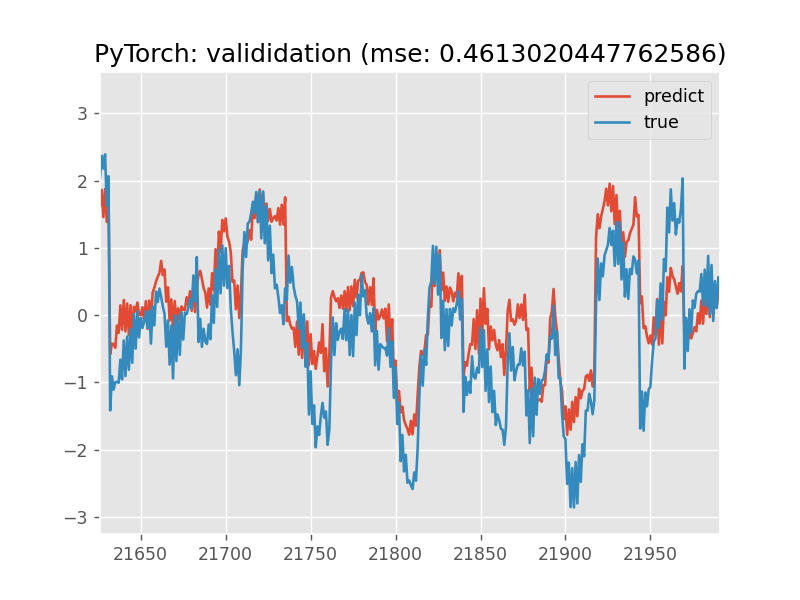

In [27]:
# PLOT PREDICTION VERSUS TRUTH

trainPlotFlag = False
    
if trainPlotFlag:
    x = trainXTensor
    trainTitle = 'train'
else:
    x = validXTensor
    trainTitle = 'valididation'
    
x = x.to(device)
predict = model(x).cpu().detach().numpy()

if predict.shape[1] == 1:
    yPred = predict[:,0]
    if trainPlotFlag:
        yTrue = yTrainTimeDomain[:,0]
    else:
        yTrue = yValidTimeDomain[:,0]
else:
    _, yPred = realSTFTtoTimeSeries(predict)
    if trainPlotFlag:
        y = y_trainRTheta
        _, yTrue = realSTFTtoTimeSeries(y)
    else:
        y = y_validRTheta
        _, yTrue = realSTFTtoTimeSeries(y)
        

lossTemp = loss_fn(torch.tensor(yPred), torch.tensor(yTrue)).item()
title = 'PyTorch: ' + trainTitle + ' (mse: %s)' % str(lossTemp)
plt.figure()
plt.plot(yPred, label='predict')
plt.plot(yTrue, label='true')
plt.legend()
plt.title(title)
plt.show()

# SCRATCH BELOW

In [ ]:
import neptune

# Create a Neptune run object
run = neptune.init_run(
    project='jettinger35/test',
    api_token=api_token,  
)

# Track metadata and hyperparameters by assigning them to the run
run["JIRA"] = "NPT-952"
run["algorithm"] = "ConvNet"

PARAMS = {
    "batch_size": 64,
    "dropout": 0.2,
    "learning_rate": 0.001,
    "optimizer": "Adam",
}
run["parameters"] = PARAMS

# Track the training process by logging your training metrics
for epoch in range(10):
    run["train/accuracy"].append(epoch * 0.6)  
    run["train/loss"].append(epoch * 0.4)

# Record the final results
run["f1_score"] = 0.66

# Stop the connection and synchronize the data with the Neptune servers
run.stop()
